## PEAK 3 Y24 phosphorylation

model PEAK3

J0: PEAK3_Y24 -> PEAK3_Y24P; J0_Vmax*PEAK3_Y24/(J0_Km + PEAK3_Y24)
J1: PEAK3_Y24P -> PEAK3_Y24; J1_Vmax*PEAK3_Y24P/(J1_Km + PEAK3_Y24P)

# State variables in the system
PEAK3_Y24=100
PEAK3_Y24P=0

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end


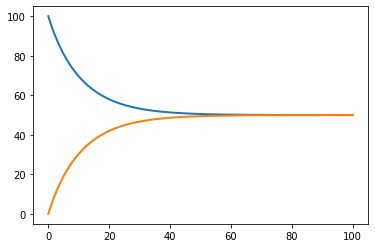

In [5]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('PEAK3_Y24',), ('PEAK3_Y24P',)))
model.add_reaction(Reaction(michaelis_menten, ('PEAK3_Y24P',), ('PEAK3_Y24',), reactant_values=0, product_values=100))

print(model.get_antimony_model())

model.simulate(0, 100, 100)
model.plot()


Antimony model compiled without error
       time, [PEAK3],  [GRB2], [PEAK3_GRB2], [CRKII], [PEAK3_CRKII], [TotalGRB2], [ASAP1], [GRB2_ASAP1], [TotalCRKII], [CRKII_ASAP1]
 [[       0,     100,     100,            0,     100,             0,         100,     100,            0,          100,             0],
  [  1.0101, 69.3584, 84.6792,      15.3208, 84.6792,       15.3208,     84.6792, 69.3584,      15.3208,      84.6792,       15.3208],
  [  2.0202,  50.968,  75.484,       24.516,  75.484,        24.516,      75.484,  50.968,       24.516,       75.484,        24.516],
  [  3.0303, 39.0342, 69.5171,      30.4829, 69.5171,       30.4829,     69.5171, 39.0342,      30.4829,      69.5171,       30.4829],
  [  4.0404, 30.8931, 65.4465,      34.5535, 65.4465,       34.5535,     65.4465, 30.8931,      34.5535,      65.4465,       34.5535],
  [ 5.05051, 25.1484, 62.5742,      37.4258, 62.5742,       37.4258,     62.5742, 25.1484,      37.4258,      62.5742,       37.4258],
  [ 6.06061, 20.997

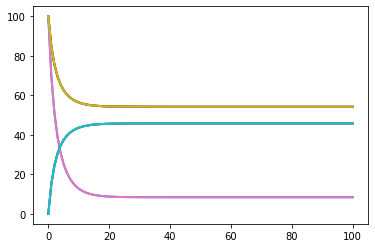

['PEAK3', 'GRB2', 'PEAK3_GRB2', 'CRKII', 'PEAK3_CRKII', 'TotalGRB2', 'ASAP1', 'GRB2_ASAP1', 'TotalCRKII', 'CRKII_ASAP1', '[PEAK3]', '[GRB2]', '[PEAK3_GRB2]', '[CRKII]', '[PEAK3_CRKII]', '[TotalGRB2]', '[ASAP1]', '[GRB2_ASAP1]', '[TotalCRKII]', '[CRKII_ASAP1]', 'default_compartment', 'E0_ka', 'E0_kd', 'E0_TA', 'E0_TB', 'E1_ka', 'E1_kd', 'E1_TA', 'E1_TB', 'E2_ka', 'E2_kd', 'E2_TA', 'E2_TB', 'E3_ka', 'E3_kd', 'E3_TA', 'E3_TB', 'E0_J0', 'E0_J1', 'E1_J0', 'E1_J1', 'E2_J0', 'E2_J1', 'E3_J0', 'E3_J1', 'init([PEAK3])', 'init([GRB2])', 'init([PEAK3_GRB2])', 'init([CRKII])', 'init([PEAK3_CRKII])', 'init([TotalGRB2])', 'init([ASAP1])', 'init([GRB2_ASAP1])', 'init([TotalCRKII])', 'init([CRKII_ASAP1])', 'init(PEAK3)', 'init(GRB2)', 'init(PEAK3_GRB2)', 'init(CRKII)', 'init(PEAK3_CRKII)', 'init(TotalGRB2)', 'init(ASAP1)', 'init(GRB2_ASAP1)', 'init(TotalCRKII)', 'init(CRKII_ASAP1)', 'init(default_compartment)', 'init(E0_ka)', 'init(E0_kd)', 'init(E0_TA)', 'init(E0_TB)', 'init(E1_ka)', 'init(E1_kd)', '

In [16]:
# use antimony's default modularity to create model 

import antimony
import roadrunner
import matplotlib.pyplot as plt

ant_model = """

model MichaelisMenten(F, B)
    J0:F -> B; Vmf * F / (Kmf + F)
    J1:B -> F; Vmb * B / (Kmb + B)

    # default values
    Vmf = 10
    Vmb = 10
    Kmf = 100
    Kmb = 100
end

model SimpleMassAction(A, B)
    J0:A -> B; ka * A - kd * B
    J1:B -> A; kd * B - ka * A
    # default values
    ka = 0.01
    kd = 0.01
end

model MassAction21(A,B,AB)
    J0:A + B -> AB; ka * A * B - kd * AB
    J1:AB -> A + B; kd * AB - ka * A * B

    # default values
    ka = 0.001
    kd = 0.01

    # bound variables
    TA = A + AB
    TB = B + AB

end


model simple_peak3
    # Examples of different rate laws and initialization
    
    E0: MassAction21(PEAK3, GRB2, PEAK3_GRB2)
    E1: MassAction21(PEAK3, CRKII, PEAK3_CRKII)
    E2: MassAction21(TotalGRB2, ASAP1, GRB2_ASAP1)
    E3: MassAction21(TotalCRKII, ASAP1, CRKII_ASAP1)

    PEAK3 = 100 
    GRB2 = 100
    CRKII = 100
    TotalGRB2 = GRB2 + PEAK3_GRB2 
    TotalCRKII = CRKII + PEAK3_CRKII
    ASAP1 = 100

end
"""

antimony.clearPreviousLoads()
antimony.freeAll()
code = antimony.loadAntimonyString(ant_model)
if code >= 0:
    mid = antimony.getMainModuleName()
    sbml_model = antimony.getSBMLString(mid)
    print('Antimony model compiled without error')
else:
    print(code)
r_model = roadrunner.RoadRunner(sbml_model)
# r_model.model['S3'] = 1
# print(r_model.model['S3'])


r_solved = r_model.simulate(0, 100, 100)

print(r_solved)

r_model.plot()

# plt.plot(r_solved['time'], label='TA')
# plt.legend()
# plt.grid()
# plt.show()

print(r_model.model.keys())
# print(r_model.model['S3'])
# print(r_solved)
# plt.plot(r_solved)


### Example simple model for parameter estimation 

model PEAK3

J0: A -> B; J0_Vmax*A/(J0_Km + A)
J1: B -> A; J1_Vmax*B/(J1_Km + B)

# State variables in the system
A=100
B=0

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end


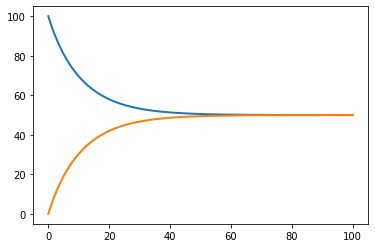

In [9]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('A',), ('B',)))
model.add_reaction(Reaction(michaelis_menten, ('B',), ('A',), reactant_values=0, product_values=100))

print(model.get_antimony_model())

model.simulate(0, 100, 100)
model.plot()

In [15]:
print(model.get_parameters().items())

dict_items([('J0_Km', 100), ('J0_Vmax', 10), ('J1_Km', 100), ('J1_Vmax', 10)])


In [11]:
print(model.get_state_variables())

{'A': 100, 'B': 0}
